In [ ]:
import numpy as np
import pandas as pd
import igraph as ig
import json
import csv
import matplotlib.pyplot as plt 
# import cairocffi
# import cairo
import networkx as nx
from scipy.spatial import Delaunay
from copy import deepcopy

In [ ]:
df = pd.read_csv('los_angeles-censustracts-2019-4-All-MonthlyAggregate.csv', usecols=['sourceid', 'dstid', 'mean_travel_time', 'month'])
df = df[df['month']==12][['sourceid','dstid','mean_travel_time']]
gd = df.values
graph_dict = {}
for sourceid,dstid,mean_travel_time in gd:
    key = tuple(np.sort([int(sourceid), int(dstid)]))
    if key in graph_dict: graph_dict[key].append(mean_travel_time)
    else: graph_dict[key] = [mean_travel_time]

with open('graph_data.txt','w') as f:
    for loc in graph_dict:
        f.write('{} {} {}\n'.format(loc[0], loc[1], np.mean(graph_dict[loc])))
        
g = ig.Graph.Read(f = 'graph_data.txt', format = 'ncol', directed = False)
gcc = g.components().giant()
print("Number of nodes and edges: ",len(gcc.vs),len(gcc.es))

Number of nodes and edges:  2649 1004955


In [ ]:
location_data = {}
with open('los_angeles_censustracts.json', 'r') as f:
    cur_data = json.loads(f.readline())
    for feature in cur_data['features']:
        coordinates = np.array(feature['geometry']['coordinates'][0][0])
        location_data[feature['properties']['MOVEMENT_ID']] = {'address': feature['properties']['DISPLAY_NAME'],
                                                          'mean_coords': np.mean(coordinates.reshape(-1,2), axis=0)}

In [ ]:
mst_edges = mst.es()
print("Coordinates near the two endpoints (the centroid locations) of a few edges:")
for e in mst_edges[:10]:
    x, y = mst.vs(e.tuple[0])[0]['name'], mst.vs(e.tuple[1])[0]['name']
    print(location_data[str(x)]['address'],location_data[str(x)]['mean_coords'], 
          location_data[str(y)]['address'],location_data[str(y)]['mean_coords'])

In [ ]:
triangles = []
while len(triangles)<1000:
    points = np.random.randint(1,high=len(gcc.vs),size=3)
    try:
        e1, e2, e3 = gcc.get_eid(points[0],points[1]), gcc.get_eid(points[1],points[2]), gcc.get_eid(points[2],points[0])
        weights = [gcc.es['weight'][e1],gcc.es['weight'][e2],gcc.es['weight'][e3]]
        triangles.append(weights)
    except: continue

counter = 0
for i in triangles:
    w1, w2, w3 = i[0], i[1], i[2]
    if w1+w2>w3 and w1+w3>w2 and w3+w2>w1: 
        counter+=1
print(counter/len(triangles))

0.886


In [ ]:
arr = gd
for i in range(0,len(arr)):
    if(arr[i][0]>arr[i][1]):
        t = arr[i][0]
        arr[i][0] = arr[i][1]
        arr[i][1] = t
newdf = pd.DataFrame(arr)
arr1 = newdf.groupby([0,1]).mean().reset_index()
arr1 = arr1.rename(columns={0: "source", 1: "sink", 2: "weight"})

g = nx.from_pandas_edgelist(arr1, 'source','sink', ['weight'])
gcc = g.subgraph(max(nx.connected_components(g), key=len))
mst = nx.minimum_spanning_tree(gcc)
mg = nx.MultiGraph()
mst_cost = 0
for i in mst.edges:
    w = mst.edges[i[0],i[1]]['weight']
    mst_cost += w
    mg.add_edge(i[0],i[1],weight=w)
    mg.add_edge(i[0],i[1],weight=w)


vertices, count = [], 0
for i in mg.nodes:
    vertices.append(i)
    count += 1
    if count>60: 
        break

costs, cur_paths = [], []
for vertex in vertices:
    tour = [u for u,v in nx.eulerian_circuit(mg,source=vertex)]
    cur_path, visited_nodes = [], set()
    for i in tour:
        if i not in visited_nodes: 
            cur_path.append(i) 
            visited_nodes.add(i) 
    cur_path.append(cur_path[0])
    cur_paths.append(cur_path)

    approx_cost = 0
    for i in range(len(cur_path)-1):
        s,t = cur_path[i], cur_path[i+1]
        w = 0
        if mst.has_edge(s,t): 
            w = mst.edges[s,t]['weight']
        else: 
            w = nx.dijkstra_path_length(gcc,s,t)
        approx_cost += w
    costs.append(approx_cost)

min_approx_cost = min(costs)
trajectory = cur_paths[np.argmin(costs)]

In [ ]:
data = json.load(open('los_angeles_censustracts.json'))
location_data = []
for i in trajectory:
    for j in range(len(data['features'])):
        if data['features'][j]['properties']['MOVEMENT_ID']==str(int(i)):
            cur_loc = data['features'][j]['geometry']['coordinates'][0]
            if len(cur_loc)==1:
                t = np.asarray(cur_loc[0]).mean(axis=0)
                location_data.append(t)
            elif len(cur_loc)==2:
                t = np.asarray(cur_loc[0]+cur_loc[1]).mean(axis=0)
                location_data.append(t)
            elif i==1932.0:
                t = np.asarray(cur_loc[0]+cur_loc[1]+cur_loc[2]+cur_loc[3]+cur_loc[4]+cur_loc[5]).mean(axis=0)
                location_data.append(t)
            else: 
                t = np.asarray(cur_loc).mean(axis=0)
                location_data.append(t)
x,y = [i[0] for i in location_data], [i[1] for i in location_data]

In [ ]:
for i in range(10):
    print('(',x[i],',',y[i],')')

( -118.12911933333332 , 34.08759475 )
( -118.13138209090911 , 34.09626386363636 )
( -118.13785063157897 , 34.09645121052631 )
( -118.13224544444446 , 34.10349303174603 )
( -118.14492316666666 , 34.098681500000005 )
( -118.15023891071432 , 34.09595766071429 )
( -118.15266638571427 , 34.09029572857144 )
( -118.15075123999998 , 34.083419626666675 )
( -118.15280849999998 , 34.098628 )
( -118.15508200990094 , 34.10732695049504 )


## Question 14

In [ ]:
lat_long = {}

with open('los_angeles_censustracts.json', 'r') as f:
    cur_data = json.loads(f.readline())
    features = cur_data['features']
    for feature in features:
        latitude = 0.0
        longitude = 0.0
        if feature['geometry']['type']=='Polygon':
            coordinates = np.array(feature['geometry']['coordinates'][0])
            for coordinate in coordinates:
                latitude += coordinate[1]
                longitude += coordinate[0]
        if feature['geometry']['type']=='MultiPolygon':
            coordinates = np.array(feature['geometry']['coordinates'][0][0])
            for coordinate in coordinates:
                latitude += coordinate[1]
                longitude += coordinate[0]
        latitude /= len(coordinates)
        longitude /= len(coordinates)
        
        lat_long[feature['properties']['MOVEMENT_ID']] = (feature['properties']['DISPLAY_NAME'], latitude, longitude)

f.close()

lat=[]
lon=[]
for i in range(1,len(lat_long)+1):
    lat.append(lat_long[str(i)][1])
    lon.append(lat_long[str(i)][2])
lat_lon = tuple(zip(lat, lon)) 
delaunay_out = Delaunay(lat_lon)




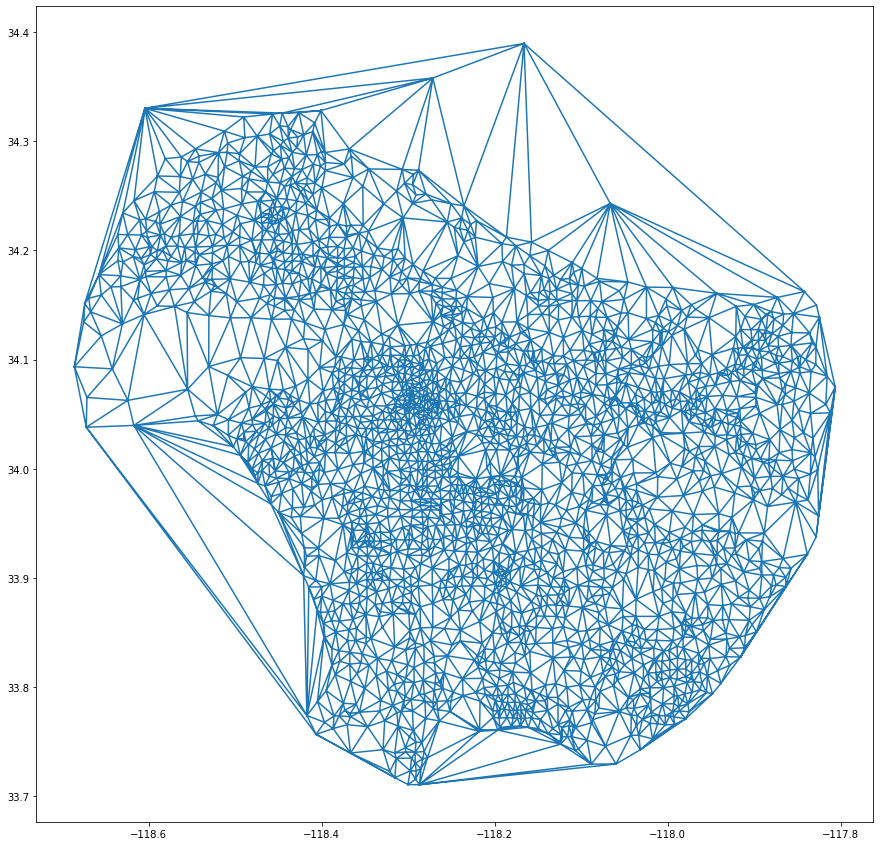

In [ ]:
plt.triplot(lon, lat, delaunay_out.simplices)
plt.plot(lon, lat,'r.')
plt.show()

## Question 16

In [ ]:
malibu= [34.04, -118.56]
long_beach =  [33.77, -118.18]
min_mal_point = np.inf
min_lb_point = np.inf
mal_point, lat_point = 0, 0
count = 0
mal_index = 0
lb_index = 0
for point in tri.points:
    
    
    lon, lat = point
    mal_dist = np.sqrt( (lon - malibu[0])**2 + (lat - malibu[1])**2 ) 
    lb_dist = np.sqrt( (lon - long_beach[0])**2 + (lat - long_beach[1])**2 ) 
    
    if mal_dist < min_mal_point:
        min_mal_point = mal_dist
        mal_point = point
        mal_index = count
    
    if lb_dist < min_lb_point:
        min_lb_point = lb_dist 
        lb_point = point 
        lb_index = count
        
    count+=1

In [ ]:
len(list(nx.edge_disjoint_paths(G_tri, lb_index, mal_index)))


5

In [ ]:
# max car formula 
vcar=(69*np.sqrt((malibu[0]-long_beach[0])**2+(malibu[1]-long_beach[1])**2))/1.05
max_car_num=(3600*vcar)/(5.4 + vcar)

min_long_beach=np.inf
min_malibu=np.inf
long_beach_node=0
malibu_node=0
for i in range(1,len(lat_lon)):
    long_beach_closest=np.sqrt(((lat_lon[i][0])-long_beach[0])**2+((lat_lon[i][1])-long_beach[1])**2)
    malibu_closest=np.sqrt((malibu[0]-lat_lon[i][0])**2+(malibu[1]-lat_lon[i][1])**2)
    if long_beach_closest<min_long_beach:
        min_long_beach=long_beach_closest
        long_beach_node=i
    if malibu_closest<min_malibu:
        min_malibu=malibu_closest
        malibu_node=i
        
print('Number of edge-disjoint paths: ',g_del.adhesion(long_beach_node,malibu_node)-1)
print('Degree Distribution of nodes (Malibu, Long Beach): ', g_del.degree(malibu_node,mode='out')-1,g_del.degree(long_beach_node,mode='in')-1)

In [ ]:
flow_metric = 0
for edge in nx.edge_disjoint_paths(g_del, lb_index, mal_index):
  
  for i in range(1, len(edge)):
    flow_metric += g_del.get_edge_data(edge[i-1], edge[i])["weight"]

print(f"The number of cars between long beach and malibu is {flow_metric/2}")

The number of cars between long beach and malibu is 109441.7645149576


In [ ]:
lb_index, mal_index

(663, 1511)

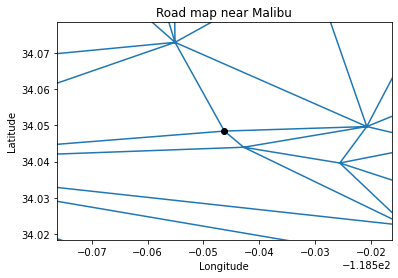

In [ ]:
plt.triplot(lon, lat, delaunay_out.simplices)
plt.ylim(lat_lon[malibu_node][0]-0.03,lat_lon[malibu_node][0]+0.03)
plt.xlim(lat_lon[malibu_node][1]-0.03,lat_lon[malibu_node][1]+0.03)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Road map near Malibu')
plt.plot(lon[malibu_node], lat[malibu_node],'o',color='black')
plt.savefig('Q16a.png',dpi=300,bbox_inches='tight')
plt.show()

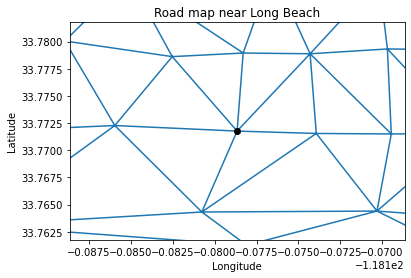

In [ ]:
plt.triplot(lon, lat, delaunay_out.simplices)
plt.ylim(lat_lon[long_beach_node][0]-0.01,lat_lon[long_beach_node][0]+0.01)
plt.xlim(lat_lon[long_beach_node][1]-0.01,lat_lon[long_beach_node][1]+0.01)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Road map near Long Beach')
plt.plot(lon[long_beach_node], lat[long_beach_node],'o',color='black')
plt.savefig('Q16b.png',dpi=300,bbox_inches='tight')
plt.show()

## Question 17

In [ ]:
g_del_prune = nx.Graph()

# Add the nodes
nodes = [i for i in range(len(tri.points))]
g_del_prune.add_nodes_from(nodes)

In [ ]:
# Add the edges using the triangulation 

duplicates = {}

for triangle in tri.simplices:
    for idx in ((0,1), (1, 2), (0, 2)):
        px, py = min(triangle[idx[0]], triangle[idx[1]]), max(triangle[idx[0]], triangle[idx[1]])
        
        
        if (px, py) not in duplicates.keys():
            
            g_del_prune.add_edge(px, py)
            duplicates[(px, py)] = 1
            

In [ ]:
trav_time = {}

for edge in g_del.edges():
    
    
    # Time taken to travel from point A to B if edge exists
    mean_travel_time = get_mean_travel_time(edge)
    
    trav_time[edge] = mean_travel_time

In [ ]:
nx.set_edge_attributes(g_del_prune, values = trav_time, name = "weight")
nx.set_node_attributes(g_del_prune, {n: coordinates[n] for n in range(len(coordinates))}, "centroid")

In [ ]:
threshold = 800

to_remove = [(a,b) for a, b, attrs in G_del.edges(data=True) if attrs["weight"] >= 800]

In [ ]:
g_del_original = g_del_prune.copy()

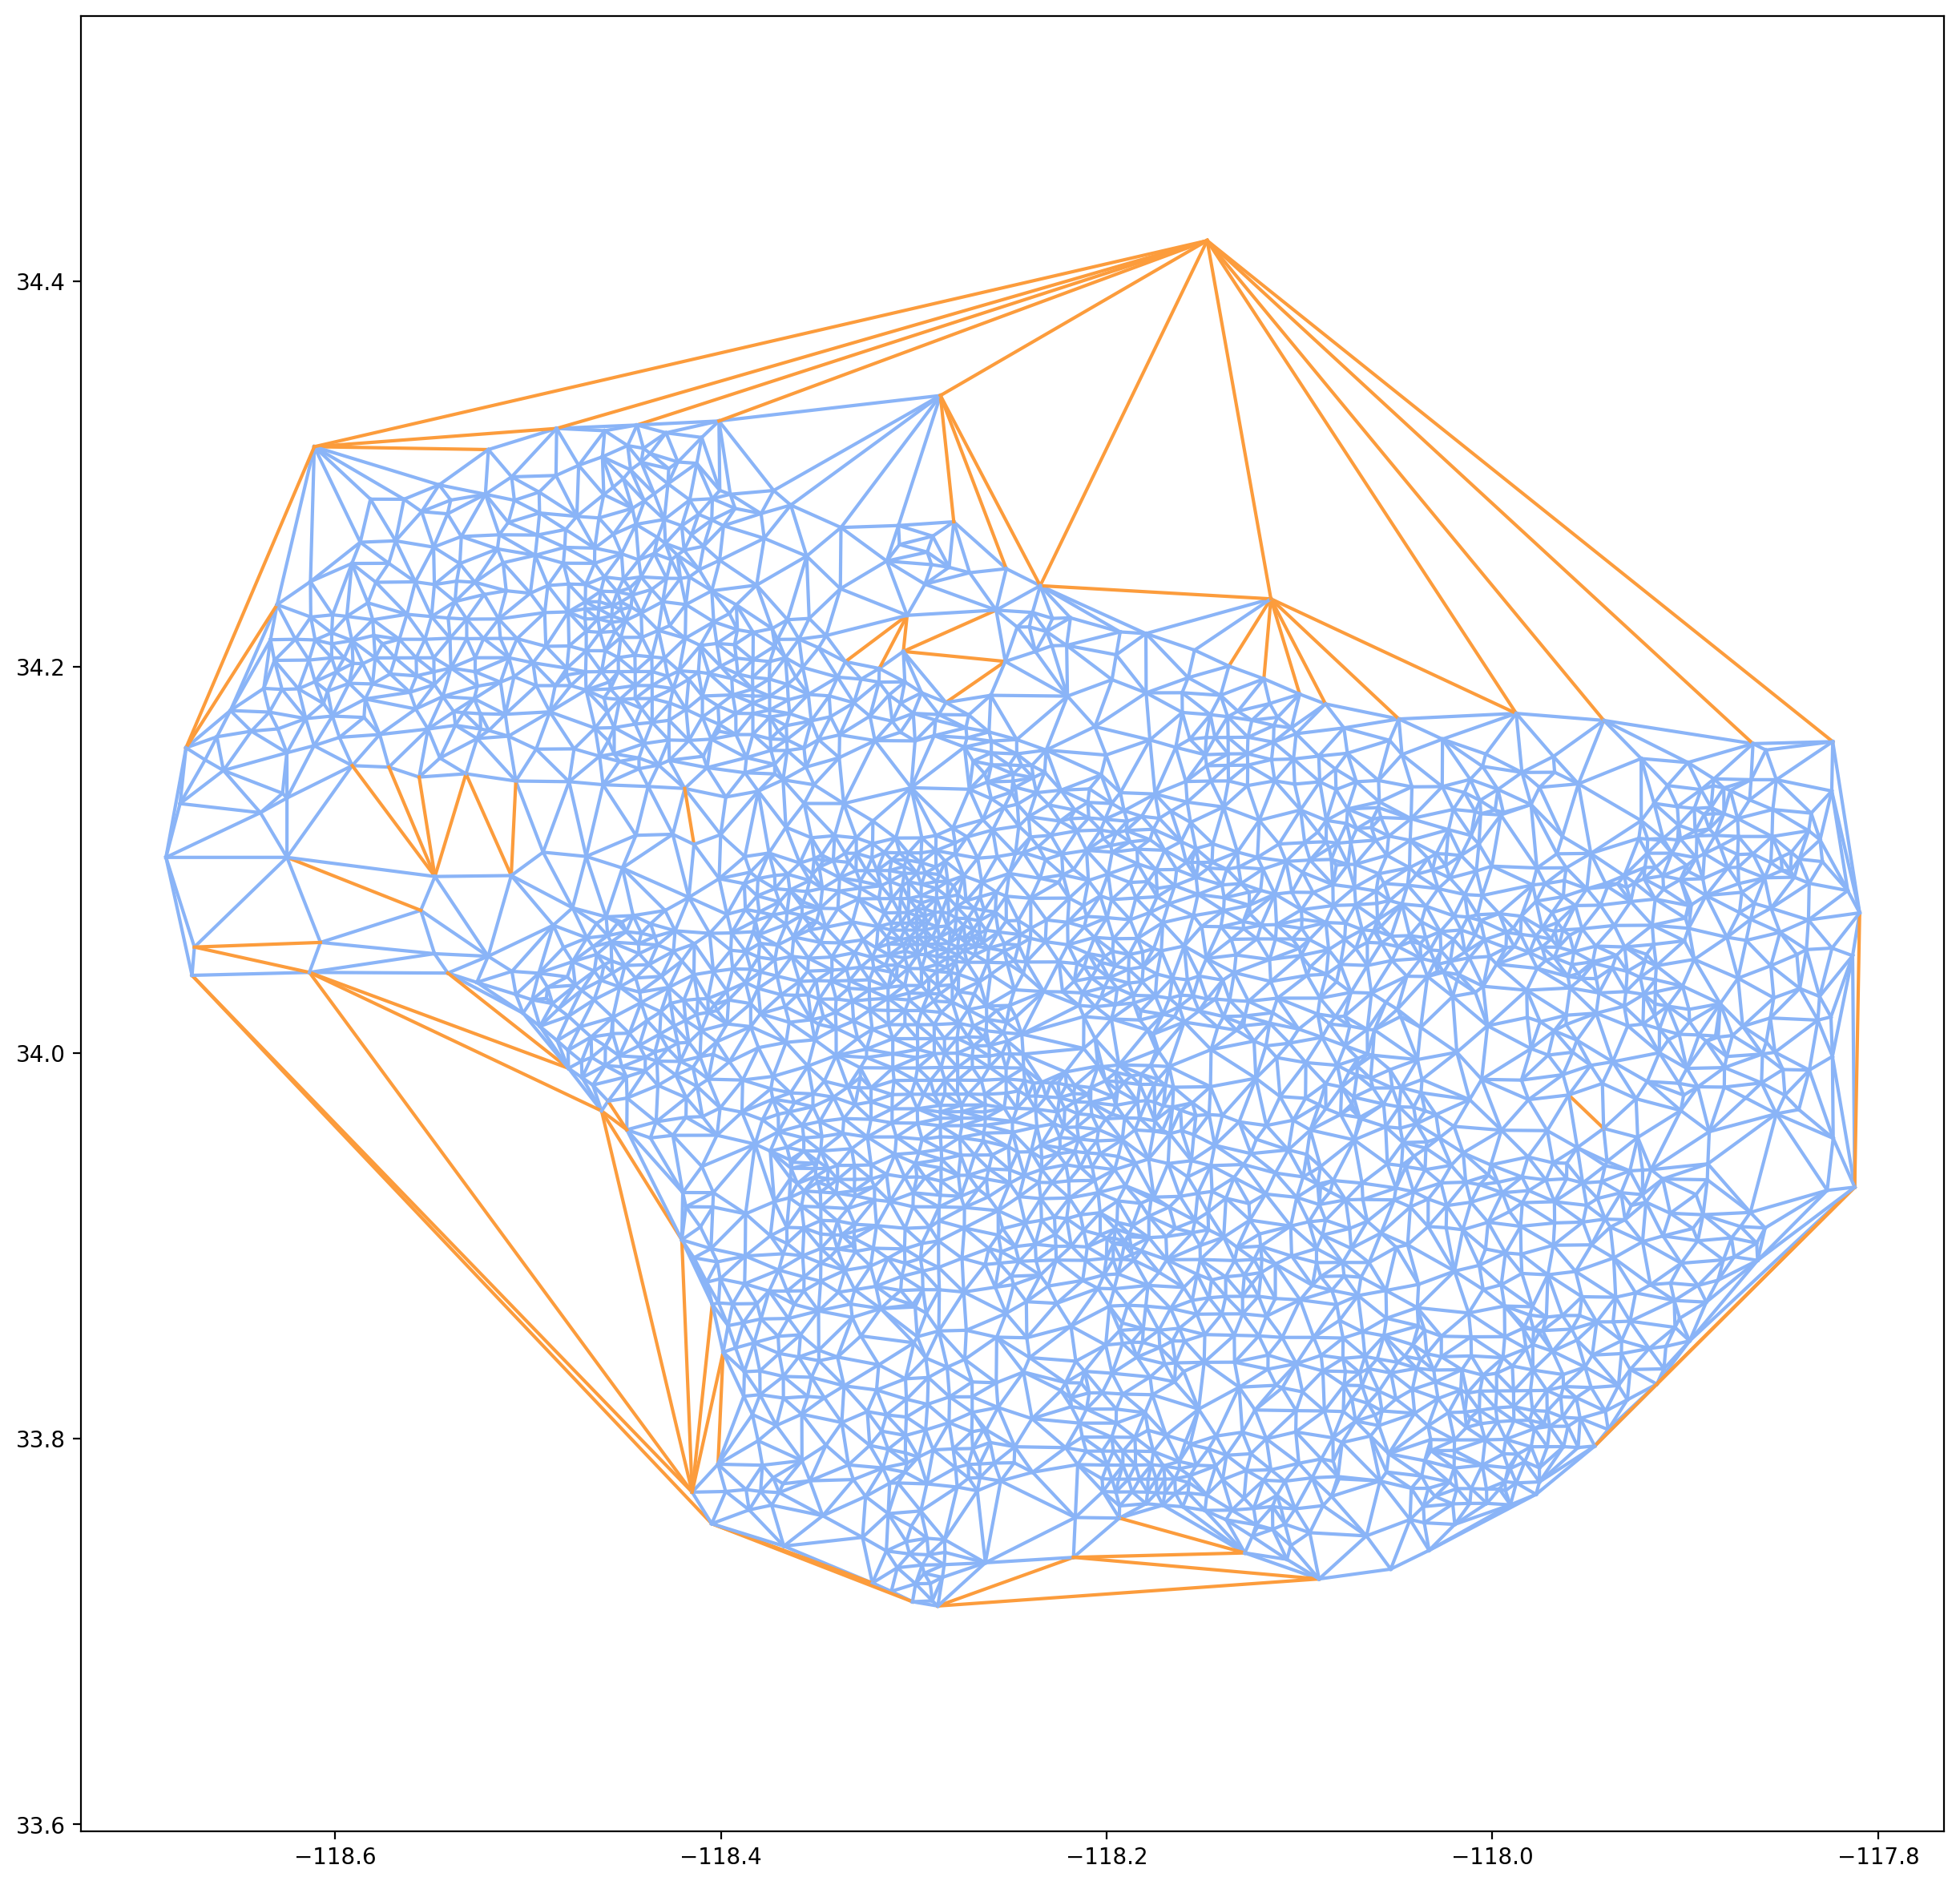

In [ ]:
plt.figure(figsize=(15,15), dpi=200)
for edge in g_del_original.edges():
    v1 = coordinates[edge[0]]
    v2 = coordinates[edge[1]]
    data = np.vstack([v1, v2])
    x = data[:, 0]
    y = data[:, 1]
    plt.plot(x, y, '#8ab4f7' if g_del_original.get_edge_data(edge[0], edge[1])["weight"] < threshold else '#fc9c3c')

plt.axis('equal')
plt.show()

## Question 18

In [ ]:
g_del_prune.remove_edges_from(to_remove)

In [ ]:
len(list(nx.edge_disjoint_paths(g_del_prune, lb_index, mal_index)))

5

In [ ]:
flow_metric = 0
for edge in nx.edge_disjoint_paths(g_del_prune, lb_index, mal_index):
  
  for i in range(1, len(edge)):
    flow_metric += g_del.get_edge_data(edge[i-1], edge[i])["weight"]

print(f"The number of cars between long beach and malibu is {flow_metric/2}")

The number of cars between long beach and malibu is 238914.81301134845


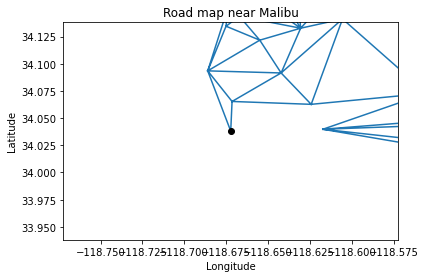

In [ ]:
plt.triplot(lon, lat, new_delaunay_out_desimplices)
plt.ylim(lat_lon[malibu_node][0]-0.1,lat_lon[malibu_node][0]+0.1)
plt.xlim(lat_lon[malibu_node][1]-0.1,lat_lon[malibu_node][1]+0.1)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Road map near Malibu')
plt.plot(lon[malibu_node], lat[malibu_node],'o',color='black')
plt.savefig('Q18a.png',dpi=300,bbox_inches='tight')
plt.show()

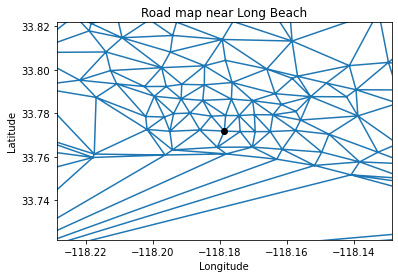

In [ ]:
plt.triplot(lon, lat, new_delaunay_out_desimplices)
plt.ylim(lat_lon[long_beach_node][0]-0.05,lat_lon[long_beach_node][0]+0.05)
plt.xlim(lat_lon[long_beach_node][1]-0.05,lat_lon[long_beach_node][1]+0.05)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Road map near Long Beach')
plt.plot(lon[long_beach_node], lat[long_beach_node],'o',color='black')
plt.savefig('Q18b.png',dpi=300,bbox_inches='tight')
plt.show()